In [11]:
SYS_PROMPT = """A stunning photograph of a newborn baby sleeping. 
(incredibly detailed, photorealistic skin texture:1.3), 
(perfectly formed face:1.2), closed eyes, peaceful expression. 
Lying in a soft, out-of-focus crib with warm blankets. 
(soft cinematic lighting:1.1), shallow depth of field, bokeh."""

SYS_NEG_PROMPT = """deformed, disfigured, (malformed:1.4), (extra limbs:1.3), extra fingers, fused fingers, misplaced limbs, artifacts, noise, blurry, grainy, weird textures, (anatomical errors:1.2), ugly"""

In [2]:
import torch
# Changed pipeline import to StableDiffusionXLControlNetPipeline
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoPipelineForImage2Image, StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image
from PIL import Image
import numpy as np
import cv2

print("Loading Depth ControlNet model...")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0", # Depth ControlNet model
    torch_dtype=torch.float16,
    variant="fp16", 
    use_safetensors=True
)
print("ControlNet model loaded.")

print("Pipeline loaded and moved to GPU.")

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    torch_dtype = torch.float16,
    variant = "fp16",

    use_safetensors=True
)

# Enable memory optimizations
pipeline.enable_model_cpu_offload() # Offload parts to CPU to save VRAM
# pipeline.enable_xformers_memory_efficient_attention() # Use if xformers is installed

Loading Depth ControlNet model...
ControlNet model loaded.
Pipeline loaded and moved to GPU.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [9]:
def preprocess_img_improved(url, res: tuple[int, int] = (1024, 1024)):
    """Preprocesamiento mejorado con suavizado y operaciones morfológicas."""
    try:
        img = Image.open(url).convert("L").resize(res, Image.LANCZOS)
    except Exception as e:
        print(f"Error abriendo la imagen: {e}")
        return None

    img_np = np.array(img)

    # 1. Filtro de Mediana para quitar ruido "punteado"
    # El segundo parámetro (ksize) debe ser un entero impar. Prueba con 3, 5, o 7.
    denoised_img = cv2.medianBlur(img_np, 5)

    # 2. Operación de Apertura para eliminar pequeños artefactos brillantes
    kernel = np.ones((5,5), np.uint8)
    opened_img = cv2.morphologyEx(denoised_img, cv2.MORPH_OPEN, kernel)

    # 3. CLAHE para mejorar el contraste de las formas principales
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_img = clahe.apply(opened_img)
    
    # 4. (Opcional) Reemplazar negros para evitar zonas muertas
    # mask = contrast_img < 20
    # contrast_img[mask] = 30 # Un gris muy oscuro en lugar de negro puro

    final_image = Image.fromarray(contrast_img)
    return final_image.convert("RGB")

def replace_black_with_avg(img: Image.Image, threshold=10, factor=0.5):
    """
    Replace black areas in a PIL image with a scaled average color.
    
    Args:
        img (PIL.Image): Input image (RGB).
        threshold (int): Max pixel value considered "black".
        factor (float): Scaling factor for average color (0.5 = half as bright).
    """
    arr = np.array(img)

    # Mask of near-black pixels
    mask = np.all(arr < threshold, axis=-1)

    # Compute average color of NON-black pixels
    non_black = arr[~mask]
    if len(non_black) == 0:
        avg_color = np.array([30, 30, 30])  # fallback
    else:
        avg_color = non_black.mean(axis=0) * factor

    avg_color = avg_color.astype(np.uint8)

    # Replace black pixels with avg_color
    arr[mask] = avg_color

    return Image.fromarray(arr)

def txt2img_depth_controlnet( 
    control_image_url, # URL of the image providing depth structure
    prompt=SYS_PROMPT,
    negative_prompt= SYS_NEG_PROMPT,
    
    guidance=7.5, # Guidance scale (tune this)
    controlnet_conditioning_scale=0.65, # ControlNet strength (tune this!)
    num_inference_steps=24, # Number of diffusion steps
    height=1024, # Output image height
    width=1024,  # Output image width
):
    """Generates an image from text prompt using Depth ControlNet for structure."""
    print("Preprocessing control image...")
    # Preprocess the ultrasound image to use as the ControlNet conditioning image
    control_image = preprocess_img_improved(control_image_url, res=(height, width)) 
    print(type(control_image))
    if type(control_image) is None:
        return None # Exit if preprocessing failed
    
    print("Using preprocessed image as depth conditioning map.")
    original = Image.open(control_image_url).resize((1024, 1024), Image.LANCZOS)
    #pre = replace_black_with_avg(original, threshold= 25)
    print("Running text-to-image inference pipeline...")
    # Call the StableDiffusionXLControlNetPipeline
    # Note: We DO NOT pass the 'image' parameter anymore.
    # Generation starts from noise, guided by prompt and control_image.
    output_image = pipeline(
            image = original,
            prompt=prompt,
            
            negative_prompt=negative_prompt,
            control_image=control_image, # The ultrasound image providing depth structure
            guidance_scale=guidance,
            controlnet_conditioning_scale=controlnet_conditioning_scale, 
            num_inference_steps=num_inference_steps,
            height=height, # Specify output height
            width=width,   # Specify output width
        ).images[0]
    print("Inference complete.")
    return output_image


A stunning photograph of a newborn baby sleeping. 
(incredibly detailed, photorealistic skin texture:1.3), 
(perfectly formed face:1.2), closed eyes, peaceful expression. 
Lying in a soft, out-of-focus crib with warm blankets. 
(soft cinematic lighting:1.1), shallow depth of field, bokeh.
deformed, disfigured, (malformed:1.4), (extra limbs:1.3), extra fingers, fused fingers, misplaced limbs, artifacts, noise, blurry, grainy, weird textures, (anatomical errors:1.2), ugly
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.


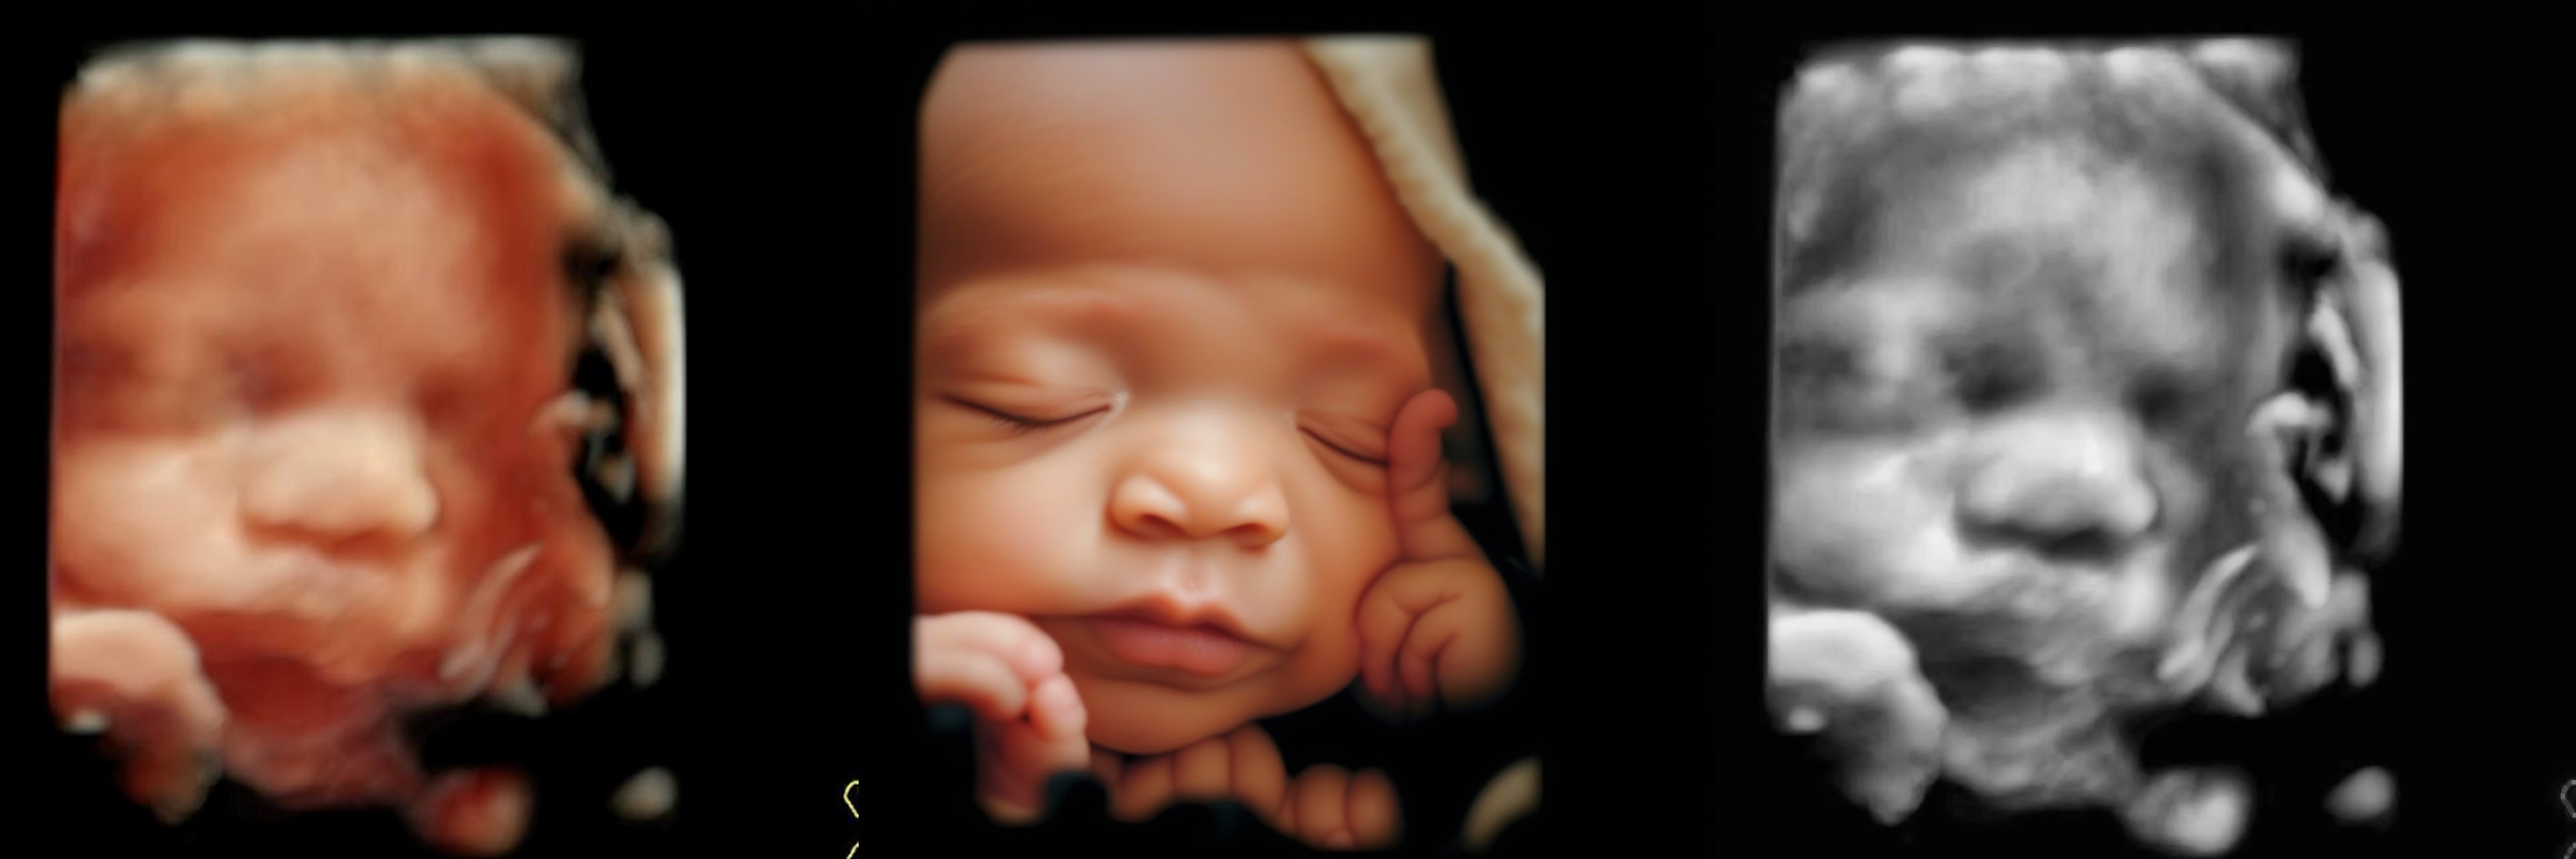

In [12]:
url = f"/home/yahir-luna/Documents/now1.png"
print(SYS_PROMPT)

print(SYS_NEG_PROMPT)
from diffusers.utils import make_image_grid


original = Image.open(url).resize((1024, 1024), Image.LANCZOS) 

output_image = txt2img_depth_controlnet(control_image_url=url) 
control = preprocess_img_improved(url)

make_image_grid([original, output_image, control], rows=1, cols=3)

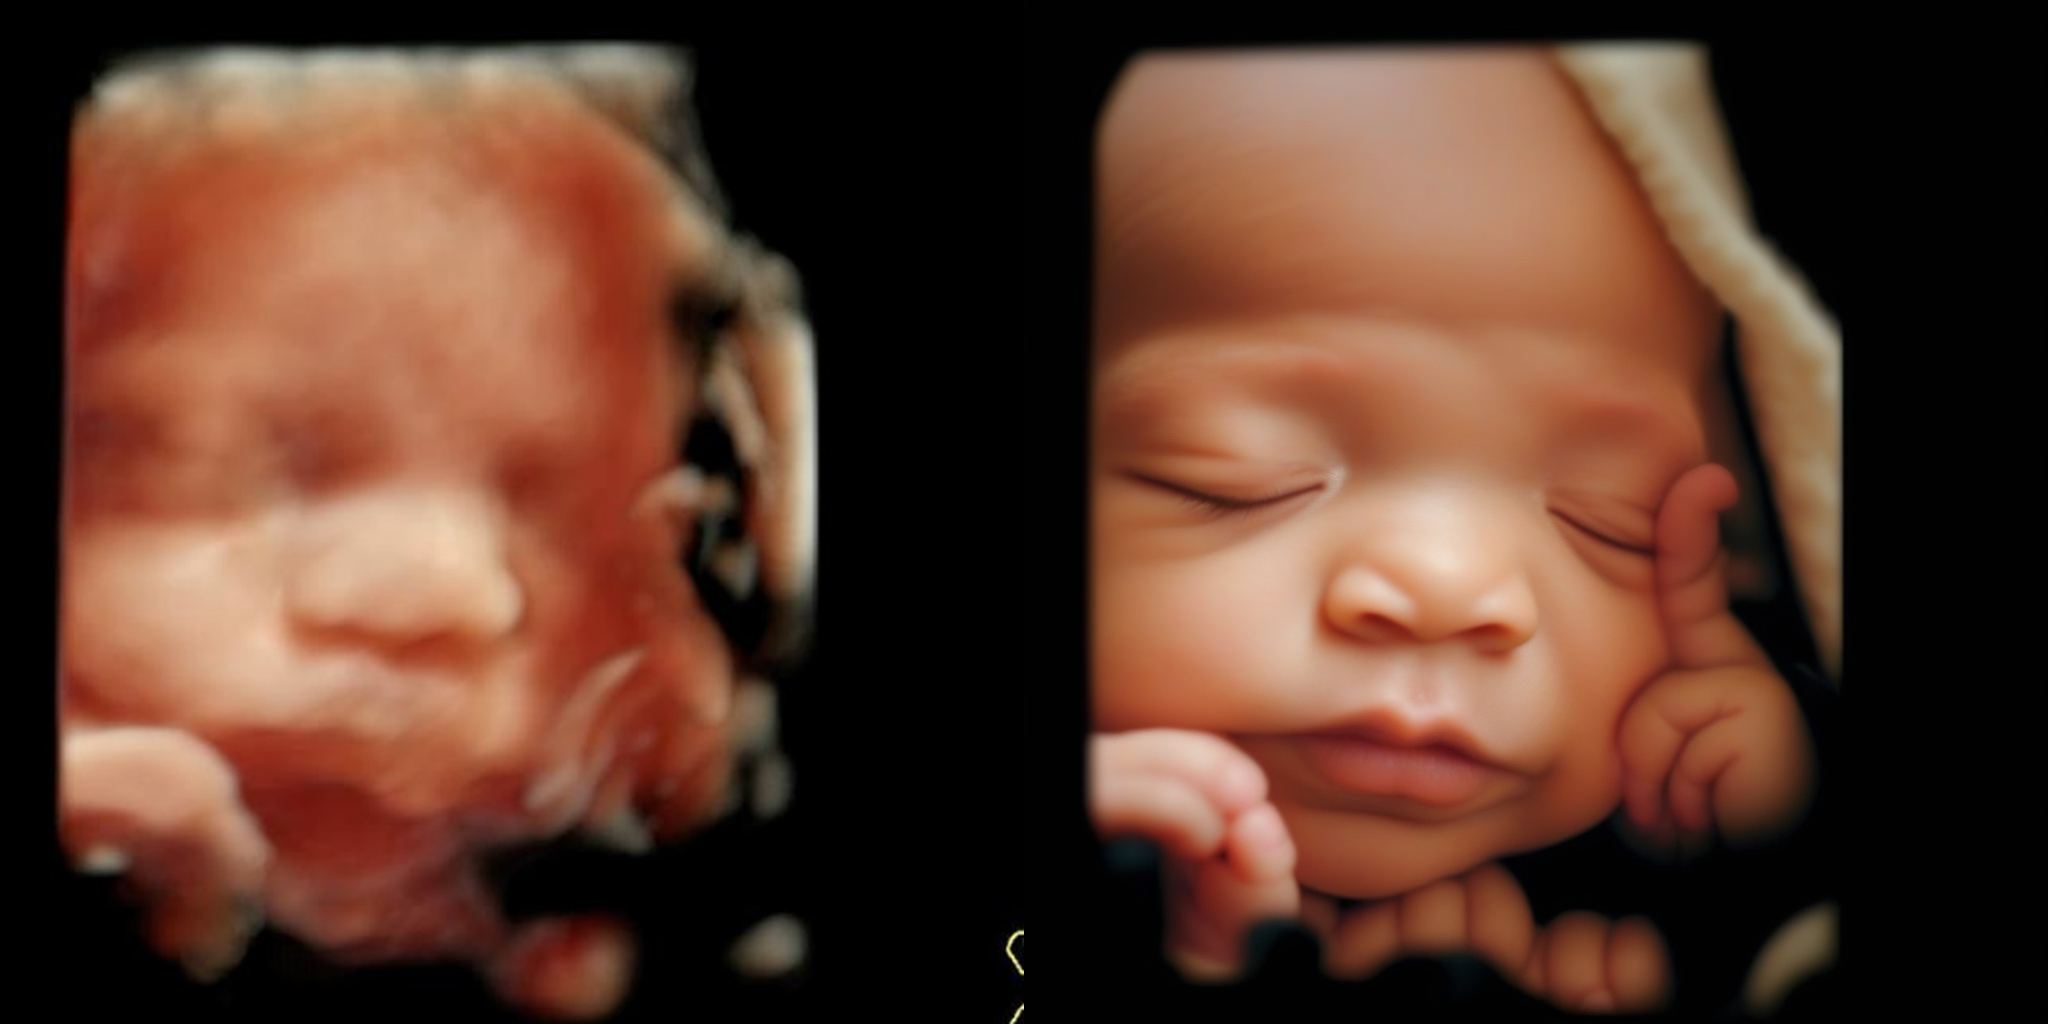

In [13]:
make_image_grid([original, output_image], rows=1, cols=2)

In [21]:
import pathlib
import os 


dir = "/home/yahir-luna/Documents/TINOK/LoRa/input"

content = os.listdir(dir)

for item in content:
    img_path = f"{dir}/{item}" 
    out_path = f"/home/yahir-luna/Documents/TINOK/LoRa/output/{item}"


    output_image = txt2img_depth_controlnet(control_image_url=img_path) 
    output_image.save(out_path)

    print(f"Image saved at {out_path}")

    


    

Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/2.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/13.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/12.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/8.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/1.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/20.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/14.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/3.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/22.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/16.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/9.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/5.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/18.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/23.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/10.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/11.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/6.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/21.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/7.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/15.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/19.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/17.png
Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/19 [00:00<?, ?it/s]

Inference complete.
Image saved at /home/yahir-luna/Documents/TINOK/LoRa/output/4.png


  0%|          | 0/3 [00:00<?, ?it/s]

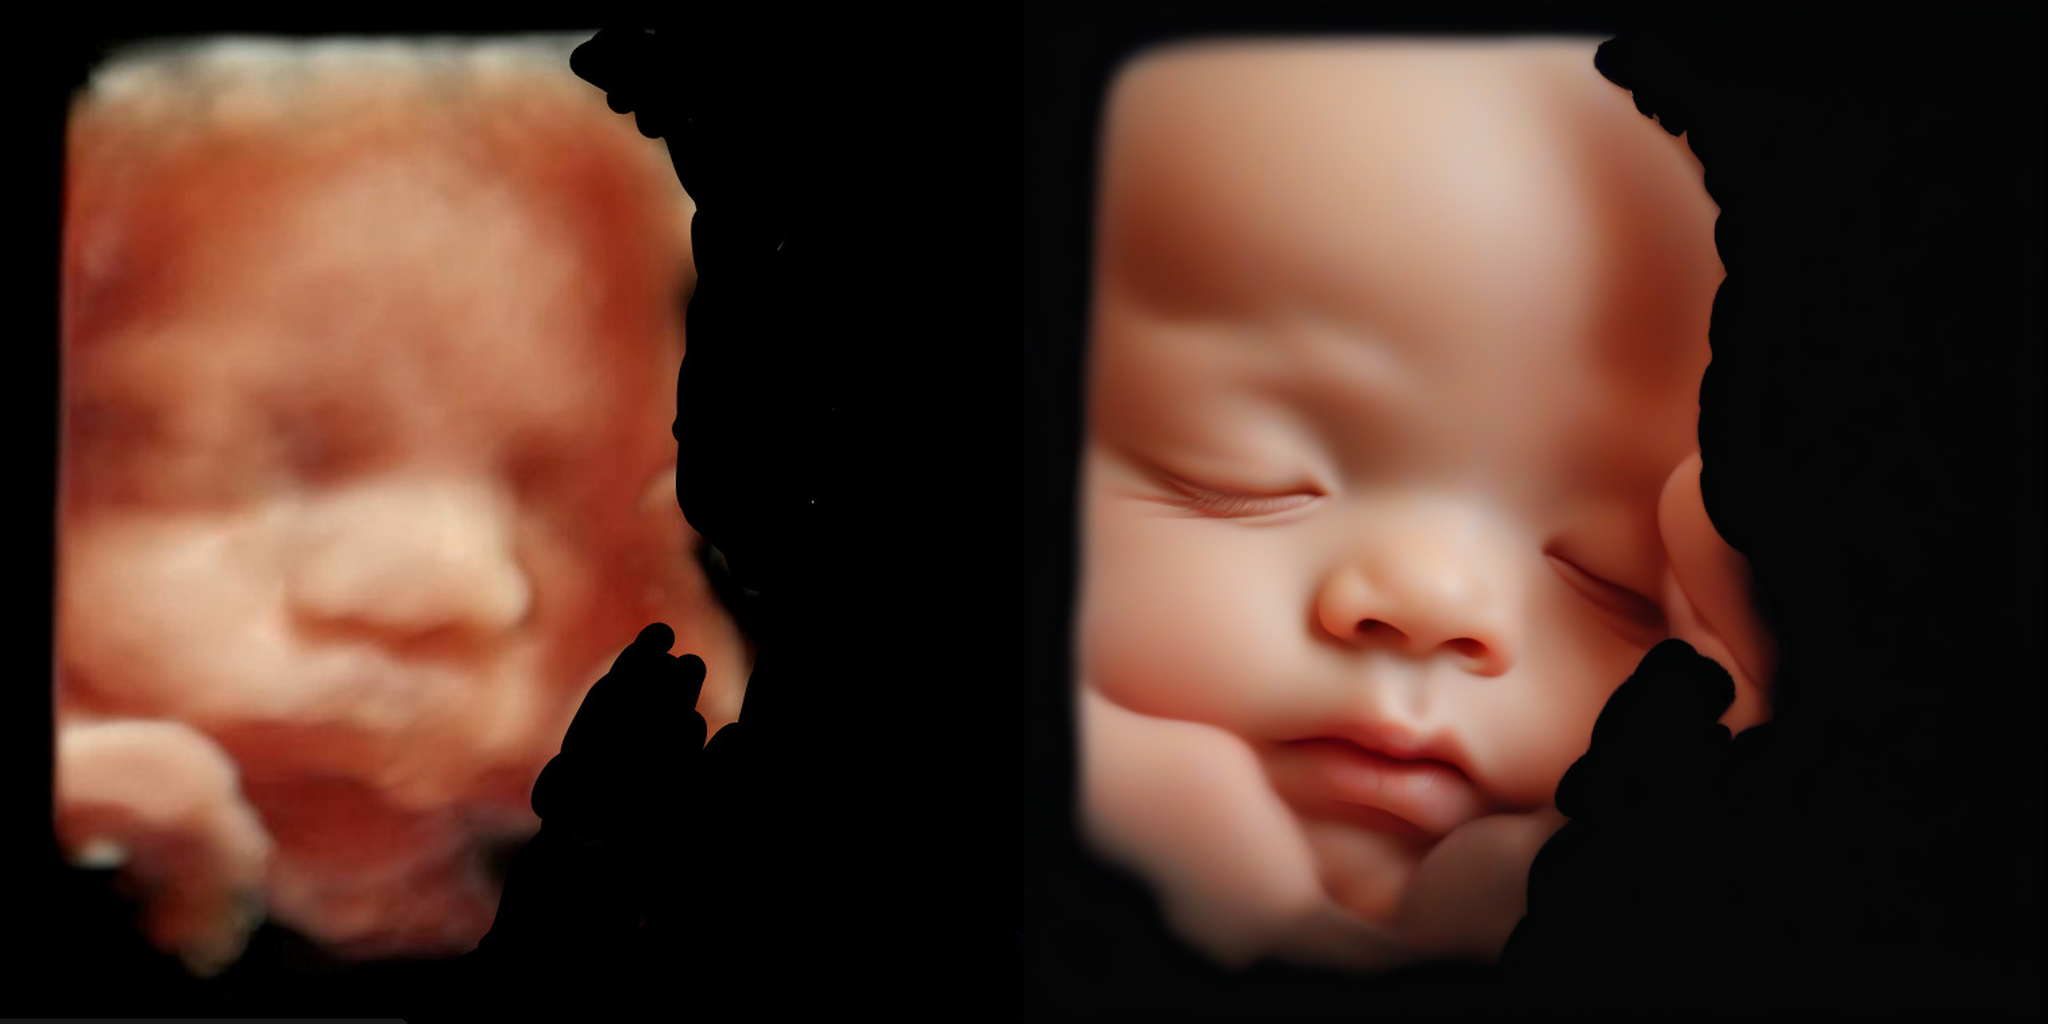

In [99]:
enhanced = refiner(
    prompt =  SYS_PROMPT ,
    negative_prompt= SYS_NEG_PROMPT,
    num_inference_steps=12,
    image = output_image,
    # guidance_scale=5.5
)
make_image_grid([original, enhanced["images"][0]], rows=1, cols=2)

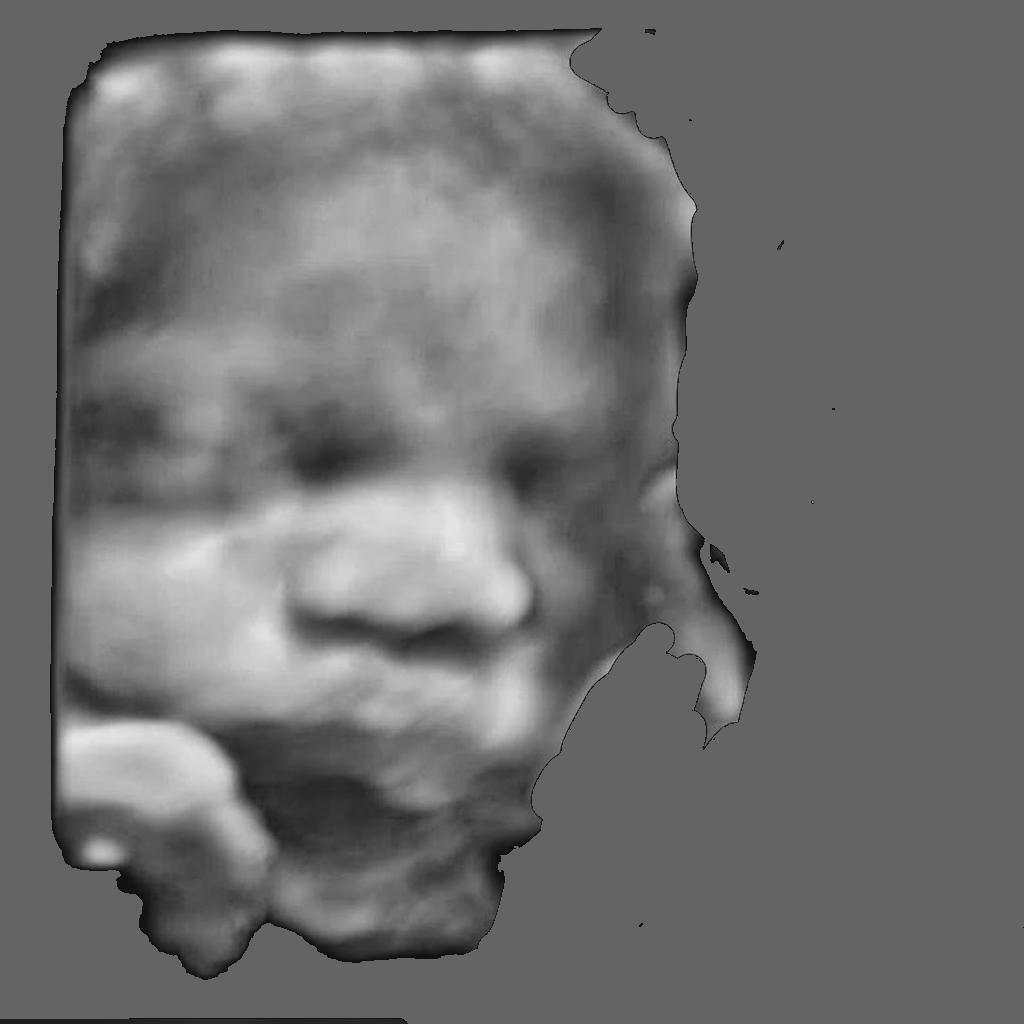

In [111]:
preprocess_img(url)

Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/20 [00:00<?, ?it/s]

Inference complete.


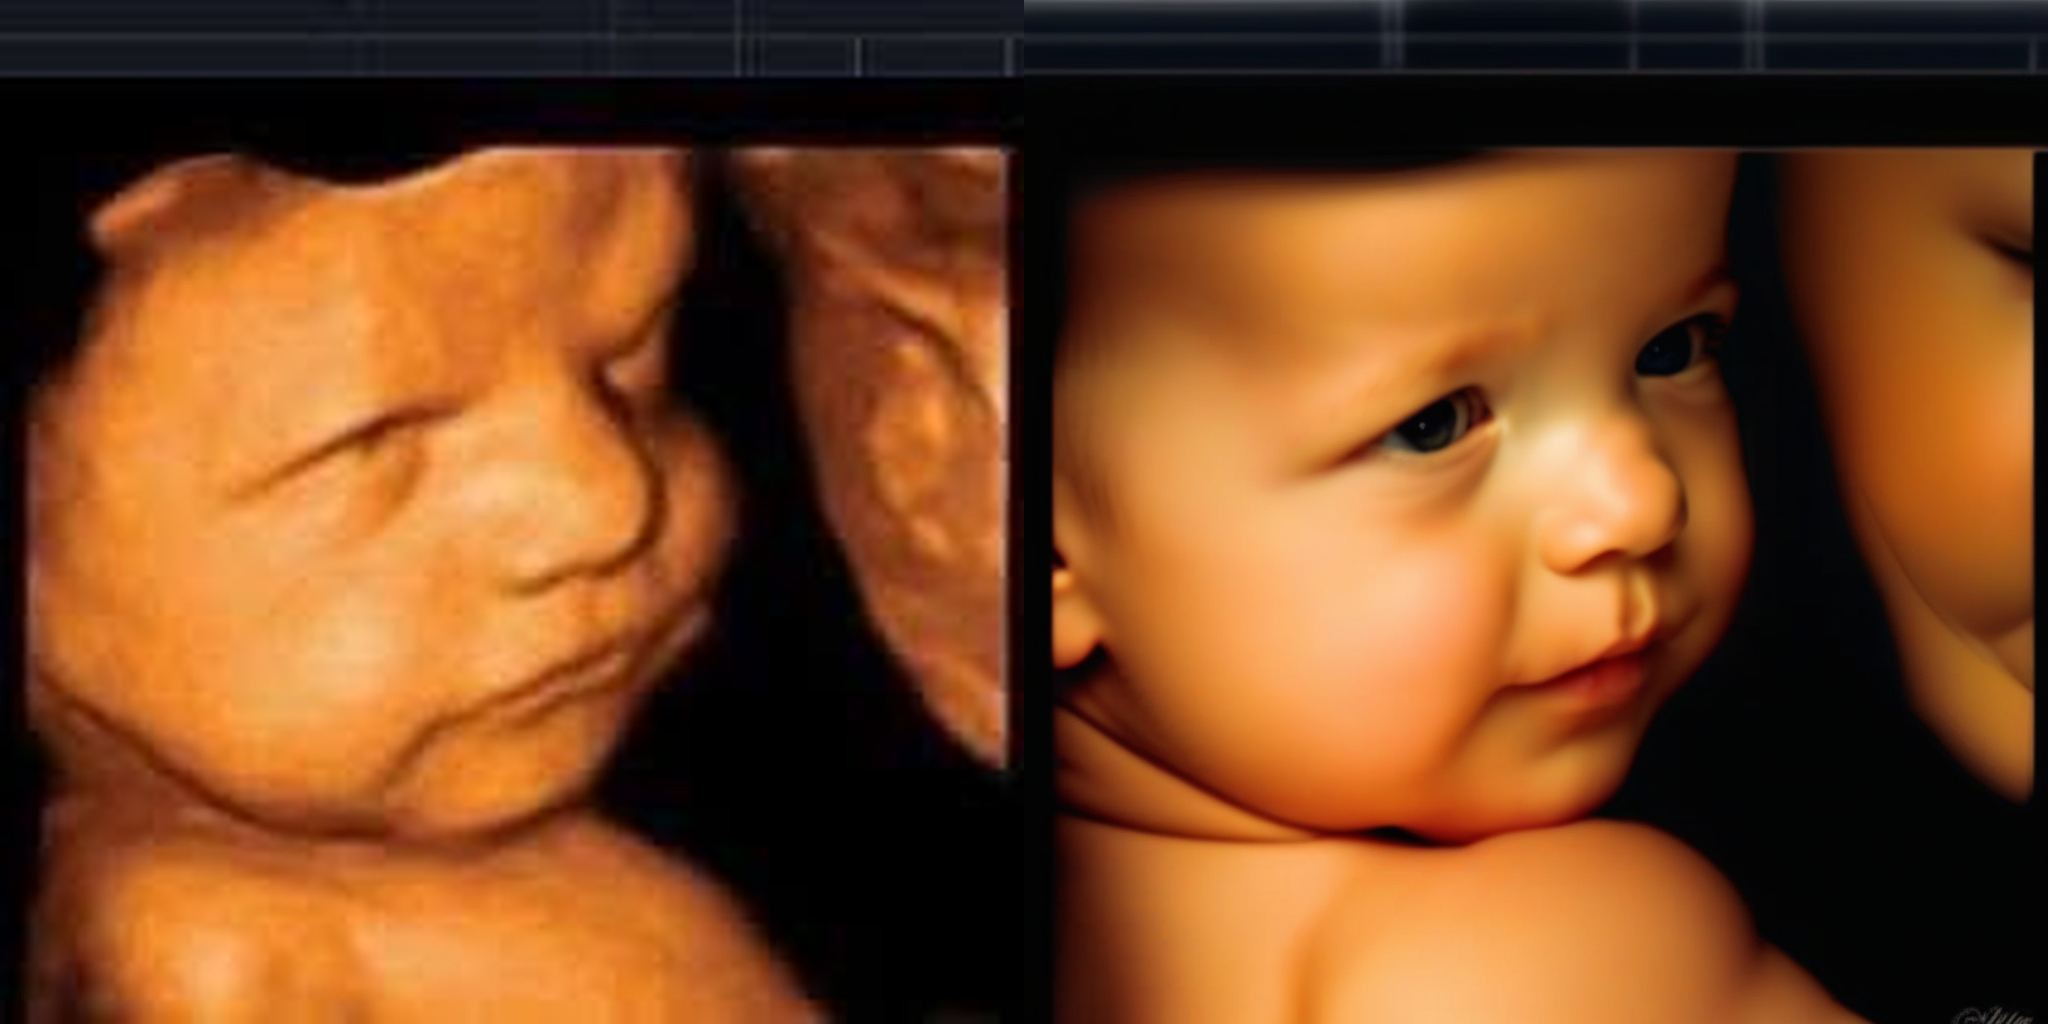

In [12]:
url = "./imgs/finaltest.jpeg" 
from diffusers.utils import make_image_grid


original = Image.open(url).resize((1024, 1024), Image.LANCZOS) 
output_image = txt2img_depth_controlnet(
    control_image_url=url,
    prompt="Beautiful bald baby",
    controlnet_conditioning_scale=.7,
    guidance= 10.5,
    num_inference_steps=25
    ) 


make_image_grid([original, output_image], rows=1, cols=2)

In [2]:
from diffusers.utils import make_image_grid    
def infer(url):


    original = Image.open(url).resize((1024, 1024), Image.LANCZOS) 
    output_image = txt2img_depth_controlnet(
        control_image_url=url,
        #prompt="Beautiful bald baby",
        controlnet_conditioning_scale=.7,
        guidance= 10.5,
        num_inference_steps=25
        ) 

    return output_image
   